# PEA plate scale and the 30 C limit

This notebook investigates the consequences of the current PEA behavior of converting
any ACA housing temperature > 30 C to 10 C for converting row/col to yag/zag.

This uses the updated star plate scale model as the reference for "true" yag/zag for a
given star and compares to the value that would be determined by the PEA and
provided to the OBC.

### Summary

The worst case value in 2027 would be over 5 arcsec radial offset from the true position.
This would result in some stars being erroneously flagged by the Kalman threshold limit check of 5 arcsec
in cases where there are also centroid offsets.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('bmh')
import chandra_aca.transform
from Ska.Matplotlib import plot_cxctime
from kadi import events
from astropy.time import Time
from Chandra.Time import DateTime
from astropy.table import Table, Column

from cheta import fetch_sci as fetch

from plate_scale_helpers import (dist, pixels_to_yagzag, yagzag_to_pixels,
                                 get_obs_dist, compare_coeffs_dashboard)

In [2]:
# row/col to yag/zag transform in the PEA
coeffs_pea = np.rad2deg(chandra_aca.transform.PIX2ACA_eeprom)

In [3]:
# row/col to yag/zag plate scale coefficients determined by 2020-02 fitting analysis
coeffs_mdl = np.array([[  8.42957944e-03,  -6.84733083e-03],
       [  2.28668273e-06,   1.38775294e-03],
       [ -1.38764910e-03,   2.56622570e-06],
       [  0.00000000e+00,   0.00000000e+00],
       [ -3.82229443e-10,   6.73615941e-10],
       [ -3.05429237e-10,   1.26847499e-09],
       [ -8.08320902e-11,  -3.87108289e-08],
       [ -1.72460168e-09,   3.48433477e-10],
       [  4.29962197e-08,  -3.27306346e-08],
       [  0.00000000e+00,   0.00000000e+00],
       [  1.52372188e-13,  -3.35659348e-11],
       [  3.25013419e-11,  -9.24719963e-14],
       [  3.29594704e-12,  -1.45179660e-12],
       [ -4.09086386e-14,  -3.26006583e-11],
       [ -1.46631941e-12,  -1.67374074e-12],
       [  1.43836754e-11,  -8.59453813e-11],
       [  3.29480263e-11,  -9.39471279e-14],
       [ -1.06374265e-12,   2.72769013e-12],
       [ -1.07588256e-10,   1.09572478e-09]])

## ACA housing temperature trend

1.15330088635


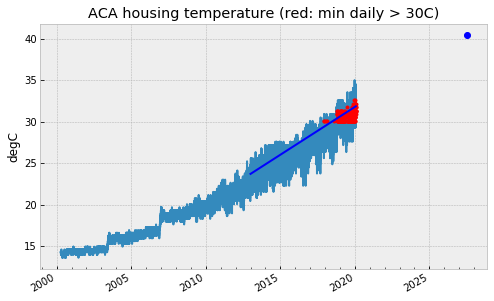

In [4]:
dat = fetch.Msid('aach1t', '2000:100', stat='daily')
dat.remove_intervals(events.normal_suns(pad=(100000, 500000)))
dat.remove_intervals(events.safe_suns(pad=(100000, 500000)))
plt.figure(figsize=(8, 5))
plt.title('ACA housing temperature (red: min daily > 30C)')
plt.ylabel('degC')
plot_cxctime(dat.times, dat.mins, 'C0');
plot_cxctime(dat.times, dat.maxes, 'C0');
ok = dat.mins > 30
plot_cxctime(dat.times[ok], dat.mins[ok], '.r');

recent = dat.times > Time('2013:001').cxcsec
c = np.polyfit(dat.times[recent], dat.maxes[recent], 1)
print(c[0] * 86400 * 365)
plot_cxctime(dat.times[recent], np.polyval(p=c, x=dat.times[recent]))
t2027 = DateTime('2027:180').secs
plot_cxctime([t2027], np.polyval(p=c, x=[t2027]), 'ob');

## Compare PEA prediction to actual at 42 C for 2027

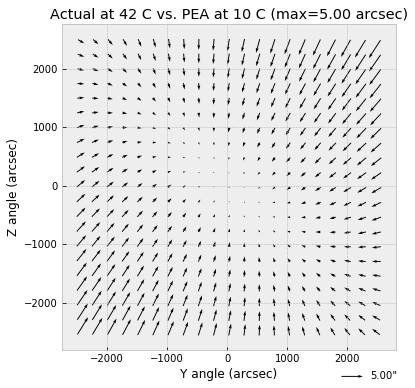

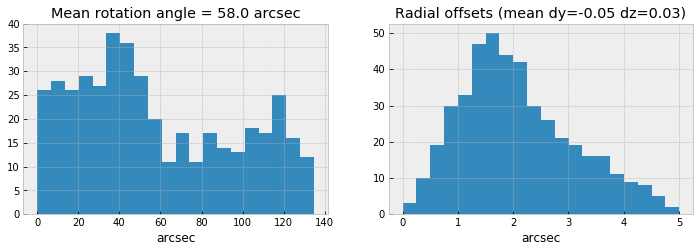

In [5]:
compare_coeffs_dashboard(coeffs1=coeffs_pea, t_aca1=10, coeffs2=coeffs_mdl, t_aca2=42, 
                         label1='PEA', label2='Actual')

## PEA centroid yag/zag errors for obsid 47523

Are the plate scale errors realistic?

https://icxc.cfa.harvard.edu/aspect/centroid_dashboard//47/47523/index.html 

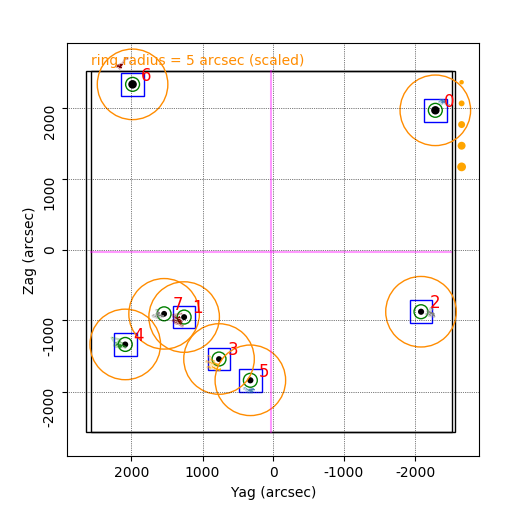

In [6]:
dat = fetch.Msid('aach1t', '2020:021:06:00:00', '2020:021:06:30:00', stat='5min')
t_aca = np.mean(dat.vals)
t_aca

33.09726

In [7]:
dat = Table.read("""
SLOT	ID	TYPE	MAG	YANG	ZANG	MEDIAN MAG	MEDIAN DY	MEDIAN DZ
0	180621720	BOT	6.392	-2271	1962	6.375	-0.98	1.18
1	180749968	BOT	8.913	1257	-952	8.812	0.76	-0.49
2	180751648	BOT	8.753	-2083	-869	8.625	-1.52	-0.33
3	180752592	BOT	9.009	763	-1543	8.812	0.38	-1.40
4	180752600	BOT	8.876	2080	-1335	8.812	0.75	-0.21
5	180758432	BOT	8.71	320	-1842	8.688	-0.22	-1.39
6	181273248	BOT	6.258	1978	2318	6.250	1.77	2.64
7	180754952	GUI	8.993	1539	-906	9.000	0.85	-0.23
""", format='ascii')


In [8]:
rows, cols = chandra_aca.transform.yagzag_to_pixels(dat['YANG'], dat['ZANG'])

In [9]:
y1, z1 = pixels_to_yagzag(rows, cols, coeff=coeffs_pea, t_aca=10)
y2, z2 = pixels_to_yagzag(rows, cols, coeff=coeffs_mdl, t_aca=t_aca)

In [10]:
dat.add_column(Column(y1 - y2, name='predict_dy'), index=8)
dat['predict_dz'] = z1 - z2

In [11]:
dat['predict_dy'].info.format = '.2f'
dat['predict_dz'].info.format = '.2f'

In [12]:
dat

<Table length=8>
 SLOT     ID    TYPE   MAG    YANG ... MEDIAN DY predict_dy MEDIAN DZ predict_dz
int64   int64   str3 float64 int64 ...  float64   float64    float64   float64  
----- --------- ---- ------- ----- ... --------- ---------- --------- ----------
    0 180621720  BOT   6.392 -2271 ...     -0.98      -0.85      1.18       0.68
    1 180749968  BOT   8.913  1257 ...      0.76       0.58     -0.49      -0.46
    2 180751648  BOT   8.753 -2083 ...     -1.52      -1.36     -0.33      -1.23
    3 180752592  BOT   9.009   763 ...      0.38       0.12      -1.4      -1.06
    4 180752600  BOT   8.876  2080 ...      0.75       1.08     -0.21      -0.59
    5 180758432  BOT    8.71   320 ...     -0.22      -0.22     -1.39      -1.40
    6 181273248  BOT   6.258  1978 ...      1.77       1.75      2.64       2.45
    7 180754952  GUI   8.993  1539 ...      0.85       0.78     -0.23      -0.36